In [14]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

<h1>P-Hacking and Multiple Comparisons Bias</h1>

Multiple comparisons bias is a pervasive problem in statistics, data science, and in general forecasting/predictions. The short explanation is that the more tests you run, the more likely you are to get an outcome that you want/expect. If you ignore the multitude of tests that failed, you are clearly setting yourself up for failure by misinterpreting what's going on in your data.

A particularly common example of this is when looking for relationships in large data sets comprising of many independent series or variables. In this case you run a test each time you evaluate whether a relationship exists between a set of variables.

<b>p-value Refresher</b>

What's important to remember is they're used to test a hypothesis given some data. Here we are testing the hypothesis that a relationship exists between two series given the series values.

<b>IMPORTANT: p-values must be treated as binary.</b>

A common mistake is that p-values are treated as more or less significant. This is bad practice as it allows for what's known as p-hacking and will result in more false positives than you expect. Effectively, you will be too likely to convince yourself that relationships exist in your data.

To treat p-values as binary, a cutoff must be set in advance. Then the p-value must be compared with the cutoff and treated as significant/not signficant. Here we'll show this.

<b>The Cutoff is our Significance Level</b>

We can refer to the cutoff as our significance level because a lower cutoff means that results which pass it are significant at a higher level of confidence. So if you have a cutoff of 0.05, then even on random data 5% of tests will pass based on chance. A cutoff of 0.01 reduces this to 1%, which is a more stringent test. We can therefore have more confidence in our results.

<h1>Experiment</h1>

We'll start by defining a data frame.

Now we'll populate it by adding N randomly generated timeseries of length T.

In [15]:
df = pd.DataFrame()

N = 20
T = 100

for i in range(N):
    X = np.random.normal(0, 1, T)
    X = pd.Series(X)
    name = 'X%s' % i
    df[name] = X

In [16]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,-1.157545,0.217650,-0.487553,1.344448,-2.009075,1.092928,0.155961,-1.325107,-1.238828,1.561380,1.623986,0.316321,0.713577,0.437509,0.293318,-0.256918,-1.299826,-1.631006,0.134329,0.388102
1,-0.092161,-0.806779,1.183139,-1.349903,-0.157429,0.490630,0.452585,-0.938230,-0.450442,0.254143,0.146844,1.083169,1.624494,0.923844,-0.771686,-0.708598,-0.016783,0.313369,0.972628,-0.055031
2,0.613429,0.288562,-0.079869,-0.389494,0.813679,-1.375571,-0.622807,-0.047088,-0.336790,-0.699341,0.576308,-2.337123,1.833127,0.254541,1.521454,1.681146,-1.166254,0.160922,0.711197,0.270805
3,-2.073863,1.003961,1.800479,-0.609792,0.790200,-1.190367,-1.358540,-1.236551,-0.266958,-0.482363,-0.926294,0.055958,0.879854,-0.263029,0.856231,1.488503,-0.758188,0.670018,1.418700,-0.196182
4,0.184200,-1.298369,-0.177939,-0.851995,-0.320657,0.035319,-1.268358,-0.226039,-0.299701,0.319908,-0.005973,1.754539,0.912685,-0.969487,-1.261910,-0.114005,0.409473,0.369395,1.042325,-0.654462


Before we check how many significant results we got, let's run out some math to check how many we'd expect. The formula for the number of pairs given N series is

$$\frac{N(N−1)}{2}$$
 
There are no relationships in our data as it's all randomly generated. If our test is properly calibrated we should expect a false positive rate of 5% given our 5% cutoff. Therefore we should expect the following number of pairs that achieved significance based on pure random chance.

In [17]:
print('Total number of combinations: {}'.format((N * (N-1) / 2)))
print('Expected number of significant combinations: {}'.format((N * (N-1) / 2) * 0.05))


Total number of combinations: 190.0
Expected number of significant combinations: 9.5


<h1>Experiment - Running Many Tests</h1>

Use Spearman Rank Correlation to evaluate the relationship between the pairs of variables. Run it 100 times and report the average number of significant pairs.

Spearman Rank Correlation is a variation of correlation that takes into account the ranks of the data. This can help with weird distributions or outliers that would confuse other measures. The test also returns a p-value, which is key here. A higher coefficient means a stronger estimated relationship.

In [18]:
def do_experiment(N, T, cutoff=0.05):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    significant_pairs = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)

            pvalue = results[1]

            if pvalue < cutoff:
                significant_pairs.append((i, j))
    
    return significant_pairs


num_experiments = 100

results = np.zeros((num_experiments,))

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.05)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

In [19]:
print('Number of significant combinations in the experiment {}'.format(np.mean(results)))

Number of significant combinations in the experiment 9.88


<h1> Run it again and visualize the data as a histogram</h1>

Draw lines in the cutoffs 0.01 and 0.05 (x axis).

In [20]:
def get_pvalues_from_experiment(N, T):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    pvalues = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)

            pvalue = results[1]

            pvalues.append(pvalue)
    
    return pvalues

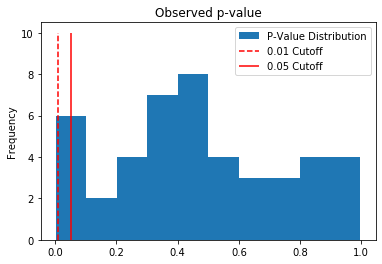

In [26]:
pvalues = get_pvalues_from_experiment(10, 100)
    
plt.vlines(0.01, 0, 10, colors='r', linestyle='--', label='0.01 Cutoff')
plt.vlines(0.05, 0, 10, colors='r', label='0.05 Cutoff')
plt.hist(pvalues, label='P-Value Distribution')
plt.legend()
plt.ylabel('Frequency')
plt.title('Observed p-value');

<h1>Increase the number of timeseries and run the experiment again</h1>

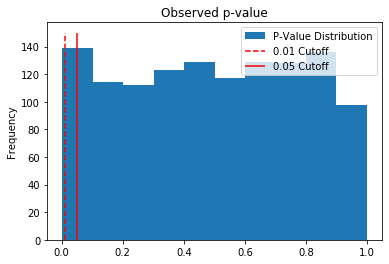

In [24]:
pvalues = get_pvalues_from_experiment(50, 100)
plt.vlines(0.01, 0, 150, colors='r', linestyle='--', label='0.01 Cutoff')
plt.vlines(0.05, 0, 150, colors='r', label='0.05 Cutoff')
plt.hist(pvalues, label='P-Value Distribution')
plt.legend()
plt.ylabel('Frequency')
plt.title('Observed p-value');

<h1>What can you conclude with this experiment?</h1>

<h1>Reducing Multiple Comparisons Bias</h1>

You can't really eliminate multiple comparisons bias, but you can reduce how much it impacts you. To do so we have two options.

<b>Option 1: Run fewer tests.</b>

<b>Option 2: Bonferroni Correction</b>

<h1>Run the experiment again with Bonferroni Correction </h1>

https://en.wikipedia.org/wiki/Bonferroni_correction

The concept behind Bonferroni is quite simple. It just says that if we run  m  tests, and we have a significance level/cutoff of  a , then we should use  a/m  as our new cutoff when determining significance. The math works out because of the following.

Let's say we run  m  tests. We should expect to see  ma  false positives based on random chance that pass out cutoff. If we instead use  a/m  as our cutoff, then we should expect to see  ma/m=a  tests that pass our cutoff. Therefore we are back to our desired false positive rate of  a .

Let's try it on our experiment above.

In [23]:
num_experiments = 100

results = np.zeros((num_experiments,))

N = 20

T = 100

desired_level = 0.05

num_tests = N * (N - 1) / 2

new_cutoff = desired_level / num_tests

print('New cutoff: {}'.format(new_cutoff))

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=new_cutoff)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n
    
np.mean(results)

New cutoff: 0.0002631578947368421


0.09